In [1]:
import re
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel, Trainer, TrainingArguments
from torch.utils.data import Dataset

# Fonction pour nettoyer les coups (supprimer les numéros de coups)
def clean_moves(game_text):
    cleaned_text = re.sub(r"\b\d+\.\s*", "", game_text)
    return cleaned_text

# Fonction pour vérifier si une partie contient des évaluations
def contains_evaluations(game_text):
    # Vérifier si le texte contient un motif du type "{ [%eval XX] }"
    return bool(re.search(r"\{ \[%eval .*?\] \}", game_text))

# Charger les parties au format PGN et les transformer en séquences complètes
def load_games(file_path, max_games, prefix="Début de la partie :"):
    with open(file_path, 'r') as file:
        content = file.read()

    # Diviser en parties en recherchant chaque occurrence de "[Event"
    games = content.split("[Event ")
    
    games_text = []
    i = 0
    for game in games[1:]:  # Ignorer le premier élément avant "[Event" s'il est vide
        lines = game.splitlines()
        moves = []
        result = None

        for line in lines:
            line = line.strip()
            if not line.endswith("]") and line:  # Ignorer les lignes vides et métadonnées
                moves.append(line)

        if moves:  # Si la partie contient des coups
            game_text = " ".join(moves)
            cleaned_game_text = clean_moves(game_text)  # Nettoyer les coups

            # Vérifier si la partie contient des évaluations
            if contains_evaluations(cleaned_game_text):
                continue  # Ignorer cette partie

            game_with_prefix = f"{prefix} {cleaned_game_text}".strip()
            games_text.append(game_with_prefix)
        
        i += 1
        if i == max_games:  # Limiter le nombre de parties chargées
            break

    return games_text

# Chargement des parties
pgn_file_path = "/kaggle/input/chess-files/lichess_db_standard_rated_2014-09.pgn"
games_text = load_games(pgn_file_path, max_games=50000)

In [3]:
# Classe Dataset personnalisée pour les parties entières
class ChessDataset(Dataset):
    def __init__(self, games, tokenizer, max_length=1024):
        self.games = games
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.games)

    def __getitem__(self, idx):
        game_text = self.games[idx]
        encodings = self.tokenizer(
            game_text,
            return_tensors="pt",
            max_length=self.max_length,
            padding="max_length",
            truncation=True
        )
        input_ids = encodings["input_ids"].squeeze()
        attention_mask = encodings["attention_mask"].squeeze()
        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": input_ids,
        }

In [4]:
# Charger le tokenizer et définir le token de padding
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token  # Utiliser le token EOS comme token de padding

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [6]:
from sklearn.model_selection import train_test_split

# Diviser les données
train_sequences, val_sequences = train_test_split(games_text, test_size=0.1)

# Créer les datasets
train_dataset = ChessDataset(train_sequences, tokenizer)
eval_dataset = ChessDataset(val_sequences, tokenizer)

In [ ]:
from torch import cuda

model = GPT2LMHeadModel.from_pretrained("gpt2-medium")

# Configurer les arguments d'entraînement
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=2,
    per_device_train_batch_size=2,
    save_steps=1000,
    logging_steps=200,
    logging_dir="./logs",
    save_total_limit=2,
    gradient_accumulation_steps=2,
    learning_rate=1.7e-5,
)

# Initialiser le Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
)

device = "cuda" if cuda.is_available() else "cpu"
print(f"L'appareil utilisé est : {device}")

# Lancer le fine-tuning
trainer.train()


config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

L'appareil utilisé est : cuda


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss
200,0.577700
400,0.343800
600,0.331500
800,0.323600
1000,0.329800
1200,0.308800
1400,0.312600
1600,0.318600
1800,0.294000
2000,0.297500


## FROM SCRATCH

In [8]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Config, TrainingArguments, Trainer

# Charger le tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token  # Définir le token de padding comme EOS

# Définir une configuration vierge pour GPT-2
"""config = GPT2Config(
    vocab_size=tokenizer.vocab_size,  # Taille du vocabulaire du tokenizer
    n_positions=1024,                # Longueur maximale de la séquence
    n_embd=768,                      # Taille des embeddings
    n_layer=12,                      # Nombre de couches
    n_head=12,                       # Nombre de têtes d'attention
)"""

# Charger la configuration de GPT-2 Medium
config = GPT2Config(
    vocab_size=tokenizer.vocab_size,  # Taille du vocabulaire
    n_positions=1024,                # Longueur maximale de la séquence
    n_embd=1024,                     # Taille des embeddings (augmentation par rapport à GPT-2 Small)
    n_layer=24,                      # Nombre de couches (GPT-2 Medium)
    n_head=16,                       # Nombre de têtes d'attention (GPT-2 Medium)
)

# Initialiser le modèle à partir de la configuration vierge
model = GPT2LMHeadModel(config)

# S'assurer que les embeddings correspondent au vocabulaire du tokenizer
model.resize_token_embeddings(len(tokenizer))

# Configurer les arguments d'entraînement SMALL
"""training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    save_steps=1000,
    logging_steps=200,
    logging_dir="./logs",
    #save_total_limit=2,
    learning_rate=5e-5,
)"""

# Configurer les arguments d'entraînement MEDIUM
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=2,
    per_device_train_batch_size=2,  # Réduit pour éviter les problèmes de mémoire
    save_steps=1000,
    logging_steps=200,
    logging_dir="./logs",
    save_total_limit=2,
    gradient_accumulation_steps=2,  # Accumuler les gradients pour compenser la réduction du batch size
    learning_rate=1.5e-5,
    #fp16=True,                      # Activer le calcul en demi-précision si un GPU est disponible
)

# Initialiser le Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,  # Assurez-vous que `train_dataset` est défini
    eval_dataset=eval_dataset,    # Assurez-vous que `eval_dataset` est défini
)

# Vérifier l'appareil utilisé (GPU ou CPU)
from torch import cuda
device = "cuda" if cuda.is_available() else "cpu"
print(f"L'appareil utilisé est : {device}")

# Lancer le fine-tuning
trainer.train()

L'appareil utilisé est : cuda


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss
200,0.750600
400,0.426100
600,0.410600
800,0.399800
1000,0.394600
1200,0.393700
1400,0.377300
1600,0.368500
1800,0.379800
2000,0.361400


KeyboardInterrupt: 

## Boucle d'entrainement

In [15]:
import torch
from torch.utils.data import DataLoader
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW
from tqdm import tqdm

# Charger le modèle GPT-2
model = GPT2LMHeadModel.from_pretrained("gpt2")

# Déplacer le modèle vers le GPU s'il est disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Configurer le DataLoader
data_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# Configurer l'optimiseur
optimizer = AdamW(model.parameters(), lr=5e-5)

# Configurer les paramètres d'entraînement
num_epochs = 3
logging_steps = 200  # Afficher la perte tous les 200 batches
save_steps = 1000    # Sauvegarder le modèle tous les 1000 batches
output_dir = "./results"

# Boucle d'entraînement
model.train()
global_step = 0  # Compteur global des étapes
for epoch in range(num_epochs):
    print(f"Époque {epoch + 1}/{num_epochs}")
    epoch_loss = 0.0

    for batch_idx, batch in enumerate(tqdm(data_loader, desc="Batches")):
        # Charger les données sur l'appareil
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumuler la perte
        epoch_loss += loss.item()
        global_step += 1

        # Afficher la perte tous les `logging_steps`
        if global_step % logging_steps == 0:
            print(f"Step {global_step}: Loss = {loss.item():.4f}")

        # Sauvegarder le modèle tous les `save_steps`
        if global_step % save_steps == 0:
            checkpoint_path = f"{output_dir}/checkpoint-{global_step}.pt"
            torch.save(model.state_dict(), checkpoint_path)
            print(f"Modèle sauvegardé à {checkpoint_path}")

    # Afficher la perte moyenne pour l'époque
    avg_epoch_loss = epoch_loss / len(data_loader)
    print(f"Perte moyenne pour l'époque {epoch + 1}: {avg_epoch_loss:.4f}")

    # Sauvegarder le modèle après chaque époque
    epoch_checkpoint_path = f"{output_dir}/checkpoint-epoch-{epoch + 1}.pt"
    torch.save(model.state_dict(), epoch_checkpoint_path)
    print(f"Modèle sauvegardé après l'époque {epoch + 1} à {epoch_checkpoint_path}")

print("Entraînement terminé.")


/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Époque 1/3


Batches:   0%|          | 55/11250 [00:41<2:21:23,  1.32it/s]


KeyboardInterrupt: 

## TPU TEST

In [6]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel, Trainer, TrainingArguments

# Charger le tokenizer et définir le token de padding
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token  # Utiliser le token EOS comme token de padding

# Charger le modèle GPT-2
model = GPT2LMHeadModel.from_pretrained("gpt2")

# Configurer les arguments d'entraînement
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=4,  # Nombre d'exemples par TPU core
    save_steps=1000,
    logging_steps=200,
    logging_dir="./logs",
    save_total_limit=2,
    tpu_num_cores=8,  # Spécifie que nous utilisons un TPU (par défaut : 8 cœurs sur Kaggle)
    save_strategy="steps",
)

# Initialiser le Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,  # Assurez-vous que `train_dataset` est défini
    eval_dataset=eval_dataset,    # Assurez-vous que `eval_dataset` est défini
)

# Lancer le fine-tuning
trainer.train()


Step,Training Loss


KeyboardInterrupt: 

In [3]:
import chess
import chess.pgn
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Chemin vers le checkpoint sauvegardé
model_path = "resultats/22"  # Répertoire contenant le checkpoint
tokenizer_path = "gpt2"  # Utilisez le tokenizer d'origine ou fine-tuné si disponible

# Charger le tokenizer
tokenizer = GPT2Tokenizer.from_pretrained(tokenizer_path)
tokenizer.pad_token = tokenizer.eos_token  # Assurez-vous que le token de padding est défini correctement

# Charger le modèle fine-tuné depuis le checkpoint
model = GPT2LMHeadModel.from_pretrained(model_path)  # Charger le checkpoint complet
model.eval()  # Mettre le modèle en mode évaluation

# Déplacer le modèle sur le GPU s'il est disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

c:\Users\briac\Desktop\EPITA\ChessLLM\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=50257, bias=False)
)

In [9]:
import chess
import chess.svg
from IPython.display import SVG
import IPython.display
from IPython.display import display, clear_output

def check_identical_scores(scores):
    """
    Compare chaque sous-liste de scores pour vérifier si elles sont identiques.
    """
    print("Vérification des sous-listes de scores...")
    identical_count = 0  # Compteur pour les sous-listes identiques
    for i in range(1, len(scores)):
        # Comparer la sous-liste actuelle avec la précédente
        if torch.allclose(scores[i], scores[i - 1], atol=1e-6):  # Vérifie l'égalité avec une tolérance
            identical_count += 1
            print(f"Les scores de l'étape {i} sont identiques à ceux de l'étape {i-1}.")
        else:
            print(f"Les scores de l'étape {i} diffèrent de ceux de l'étape {i-1}.")
    
    print(f"Nombre total de sous-listes identiques : {identical_count}/{len(scores)}")
    return identical_count


def get_keypress():
    """
    Simulation d'une touche pressée dans un environnement Jupyter.
    Utilise input() pour capturer les entrées.
    """
    return input("Appuyez sur Entrée pour continuer ou tapez 'q' pour quitter : ").strip()

def decode_and_display_tokens(sequence, tokenizer):
    """
    Décode une séquence de tokens et affiche chaque token individuellement avec ses détails.
    """
    print(f"Décodage de la séquence : {sequence}\n")
    
    for i, token_id in enumerate(sequence):
        # Décoder le token
        token_text = tokenizer.decode([token_id], skip_special_tokens=True)
        
        # Afficher les détails
        print(f"Token {i+1}: '{token_text}' (ID: {token_id})")


def generate_candidate_moves(input_sequence, num_candidates=5, tokens_for_generation=10):
    """
    Générer des séquences candidates avec leurs probabilités associées.
    """
    # Tokeniser l'entrée
    encodings = tokenizer(
        input_sequence,
        return_tensors="pt",
        padding=True,
        truncation=True,
    )
    input_ids = encodings["input_ids"].to(device)
    attention_mask = encodings["attention_mask"].to(device)

    max_length = input_ids.size(1) + tokens_for_generation

    # Générer plusieurs séquences candidates
    output_sequences = model.generate(
        input_ids=input_ids,
        attention_mask=attention_mask,  # Ajouter le mask pour un comportement fiable
        max_length=max_length,
        num_return_sequences=num_candidates,
        no_repeat_ngram_size=2,
        do_sample=True,
        top_k=50,
        top_p=0.95,
        temperature=0.7,
        output_scores=True,  # Retourne les scores pour analyser les probabilités
        return_dict_in_generate=True,
    )

    sequences = output_sequences.sequences  # Les séquences générées
    scores = output_sequences.scores        # Les scores à chaque étape (tokens x candidates)

    # Vérifier la structure des scores
    print(f"Scores shape: {len(scores)} tokens, {scores[0].shape if scores else 'N/A'} per token")

    # Calculer les probabilités pour chaque séquence
    candidate_moves = []
    for idx, sequence in enumerate(sequences):
        print(f"\nProcessing candidate sequence {idx + 1}/{num_candidates}...")

        # Obtenir les tokens générés (après l'entrée)
        generated_tokens = sequence[len(input_ids[0]):]  # Tokens générés après l'entrée

        # Initialiser les variables pour extraire le prochain coup
        next_move_tokens = []
        space_count = 0

        # Parcourir les tokens générés pour former le coup complet
        for token in generated_tokens:
            token_text = tokenizer.decode([token], skip_special_tokens=True)
            next_move_tokens.append(token_text)

            if " " in token_text:
                space_count += token_text.count(" ")

            # Arrêter après le deuxième espace
            if space_count == 2:
                break

        # Concaténer les tokens pour former le coup complet
        next_move = "".join(next_move_tokens)

        # Vérifier si next_move contient un 2ème espace avec un caractère après
        second_space_index = next_move.find(" ", next_move.find(" ") + 1)  # Index du 2ème espace
        if second_space_index != -1 and second_space_index + 1 < len(next_move):
            print("test cut spaces: " + next_move[second_space_index:])
            next_move = next_move[:second_space_index]  # Couper la chaîne après le 2ème espace

        # Optionnel : Afficher pour débogage
        print("Prochain coup :", next_move)
        print("longueur du coup :", len(next_move))

        # Calculer la probabilité cumulée du coup
        tokenized_move = tokenizer.encode(next_move, add_special_tokens=False)
        print(f"Nombre de tokens dans 'tokenized_move': {len(tokenized_move)}")

        # Extraire les scores spécifiques à cette séquence
        step_scores = [scores[token_idx][idx] for token_idx in range(len(generated_tokens))]
        print("longueur des step_scores :", len(step_scores))

        if len(tokenized_move) > len(step_scores):
            print("Attention : Les tokens sont plus longs que les scores. Ajustement nécessaire.")
            tokenized_move = tokenized_move[:len(step_scores)]

        move_probability = calculate_probability(step_scores, tokenized_move)
        candidate_moves.append((next_move, move_probability))

    return candidate_moves




def calculate_probability(scores, tokenized_move):
    """
    Calcule la probabilité cumulative pour un coup spécifique.
    Affiche les probabilités de chaque token pour le débogage.
    """
    prob = 1.0
    print(f"\nCalcul des probabilités pour le coup : {tokenized_move} (en tokens)")
    
    for i, (token_id, step_score) in enumerate(zip(tokenized_move, scores)):
        # Convertir les scores logits en probabilités via softmax
        probabilities = torch.softmax(step_score, dim=-1)
        
        # Extraire la probabilité du token en question
        token_prob = probabilities[token_id].item()
        prob *= token_prob

        # Décoder le token pour l'afficher en clair
        token_text = tokenizer.decode([token_id], skip_special_tokens=True)
        
        # Afficher les détails pour chaque token
        print(f"Token {i+1}: '{token_text}' (ID: {token_id}) - Probabilité: {token_prob:.6f}")

    print(f"Probabilité cumulative pour le coup : {prob:.6f}\n")
    return prob

def apply_move_to_board(board, move_text):
    """
    Appliquer un coup au format SAN (Standard Algebraic Notation) à un échiquier.
    """
    try:
        move = board.parse_san(move_text)  # Convertir le texte en un coup compréhensible par python-chess
        board.push(move)  # Appliquer le mouvement à l'échiquier
        return True
    except ValueError:
        return False


def display_board(board):
    """
    Affiche l'échiquier dans un format réduit graphiquement dans un notebook Jupyter.
    """
    svg_code = chess.svg.board(board=board, size=250)  # Ajuster la taille à 250 pixels
    display(SVG(svg_code))

def test_chess_model():
    """
    Tester le modèle de manière interactive.
    """
    board = chess.Board()  # Initialiser un nouvel échiquier
    input_sequence = "Début de la partie :"
    
    print("Appuyez sur Entrée pour générer un coup, ou 'q' pour quitter.")

    while not board.is_game_over():
        # Afficher l'échiquier dans le notebook
        display_board(board)
        print("\nMove history:", input_sequence)

        # Générer les candidats
        candidates = generate_candidate_moves(input_sequence)
        print("\nCandidates and probabilities:")
        for move, prob in candidates:
            print(f"{move.strip()}: {prob:.4f}")  # Nettoyer les espaces autour du coup

        # Filtrer les coups légaux
        legal_moves = [(move.strip(), prob) for move, prob in candidates if apply_move_to_board(board.copy(), move.strip())]
        if not legal_moves:
            print("No valid moves generated. Stopping.")
            break

        # Attendre une entrée utilisateur
        key = get_keypress()
        if key == "q":  # Quitter si l'utilisateur appuie sur 'q'
            print("Arrêt de la partie.")
            break
        elif key == "\r":  # Générer un coup si l'utilisateur appuie sur Entrée
            # Sélectionner le coup avec la probabilité la plus élevée
            best_move, _ = max(legal_moves, key=lambda x: x[1])

            # Appliquer le meilleur coup
            apply_move_to_board(board, best_move)
            input_sequence += f" {best_move}"

            # Vérifier si la partie est terminée
            if board.is_game_over():
                print("\nGame over!")
                print("Result:", board.result())
                break
        else:
            print("Appuyez sur Entrée pour continuer ou 'q' pour quitter.")

    # Afficher l'échiquier final
    display_board(board)
    print("\nPartie terminée. Résultat:", board.result())


In [6]:
input_sequence = "Début de la partie : d4 e5"
candidates = generate_candidate_moves(input_sequence, num_candidates=10, tokens_for_generation=5)

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Scores shape: 5 tokens, torch.Size([10, 50257]) per token

Processing candidate sequence 1/10...
test cut spaces:  N
Prochain coup :  dxe5
longueur du coup : 5
Nombre de tokens dans 'tokenized_move': 3
longueur des step_scores : 5

Calcul des probabilités pour le coup : [288, 27705, 20] (en tokens)
Token 1: ' d' (ID: 288) - Probabilité: 0.857855
Token 2: 'xe' (ID: 27705) - Probabilité: 1.000000
Token 3: '5' (ID: 20) - Probabilité: 1.000000
Probabilité cumulative pour le coup : 0.857855


Processing candidate sequence 2/10...
test cut spaces:  N
Prochain coup :  dxe5
longueur du coup : 5
Nombre de tokens dans 'tokenized_move': 3
longueur des step_scores : 5

Calcul des probabilités pour le coup : [288, 27705, 20] (en tokens)
Token 1: ' d' (ID: 288) - Probabilité: 0.857855
Token 2: 'xe' (ID: 27705) - Probabilité: 1.000000
Token 3: '5' (ID: 20) - Probabilité: 1.000000
Probabilité cumulative pour le coup : 0.857855


Processing candidate sequence 3/10...
test cut spaces:  f
Prochain coup :

In [7]:
print(candidates)

[(' dxe5', 0.8578552603721619), (' dxe5', 0.8578552603721619), (' dxe5', 0.8578552603721619), (' dxe5', 0.8578552603721619), (' dxe5', 0.8578552603721619), (' c4', 0.07150117100952214), (' dxe5', 0.8578552603721619), (' dxe5', 0.8578552603721619), (' dxe5', 0.8578552603721619), (' dxe5', 0.8578552603721619)]


Appuyez sur Entrée pour générer un coup, ou 'q' pour quitter.


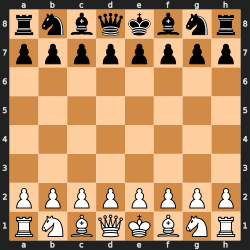

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Move history: Début de la partie :
Scores shape: 10 tokens, torch.Size([5, 50257]) per token

Processing candidate sequence 1/5...
test cut spaces:  d
Prochain coup :  d4
longueur du coup : 3
Nombre de tokens dans 'tokenized_move': 2
longueur des step_scores : 10

Calcul des probabilités pour le coup : [288, 19] (en tokens)
Token 1: ' d' (ID: 288) - Probabilité: 0.224794
Token 2: '4' (ID: 19) - Probabilité: 1.000000
Probabilité cumulative pour le coup : 0.224794


Processing candidate sequence 2/5...
test cut spaces:  e
Prochain coup :  e4
longueur du coup : 3
Nombre de tokens dans 'tokenized_move': 2
longueur des step_scores : 10

Calcul des probabilités pour le coup : [304, 19] (en tokens)
Token 1: ' e' (ID: 304) - Probabilité: 0.775206
Token 2: '4' (ID: 19) - Probabilité: 1.000000
Probabilité cumulative pour le coup : 0.775206


Processing candidate sequence 3/5...
test cut spaces:  e
Prochain coup :  e4
longueur du coup : 3
Nombre de tokens dans 'tokenized_move': 2
longueur des st

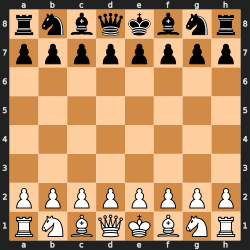

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Move history: Début de la partie :
Scores shape: 10 tokens, torch.Size([5, 50257]) per token

Processing candidate sequence 1/5...
test cut spaces:  c
Prochain coup :  e4
longueur du coup : 3
Nombre de tokens dans 'tokenized_move': 2
longueur des step_scores : 10

Calcul des probabilités pour le coup : [304, 19] (en tokens)
Token 1: ' e' (ID: 304) - Probabilité: 0.775206
Token 2: '4' (ID: 19) - Probabilité: 1.000000
Probabilité cumulative pour le coup : 0.775206


Processing candidate sequence 2/5...
test cut spaces:  e
Prochain coup :  e4
longueur du coup : 3
Nombre de tokens dans 'tokenized_move': 2
longueur des step_scores : 10

Calcul des probabilités pour le coup : [304, 19] (en tokens)
Token 1: ' e' (ID: 304) - Probabilité: 0.775206
Token 2: '4' (ID: 19) - Probabilité: 1.000000
Probabilité cumulative pour le coup : 0.775206


Processing candidate sequence 3/5...
test cut spaces:  e
Prochain coup :  e4
longueur du coup : 3
Nombre de tokens dans 'tokenized_move': 2
longueur des st

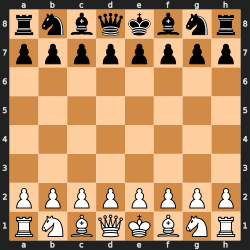

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Move history: Début de la partie :
Scores shape: 10 tokens, torch.Size([5, 50257]) per token

Processing candidate sequence 1/5...
test cut spaces:  c
Prochain coup :  e4
longueur du coup : 3
Nombre de tokens dans 'tokenized_move': 2
longueur des step_scores : 10

Calcul des probabilités pour le coup : [304, 19] (en tokens)
Token 1: ' e' (ID: 304) - Probabilité: 0.775206
Token 2: '4' (ID: 19) - Probabilité: 1.000000
Probabilité cumulative pour le coup : 0.775206


Processing candidate sequence 2/5...
test cut spaces:  c
Prochain coup :  e4
longueur du coup : 3
Nombre de tokens dans 'tokenized_move': 2
longueur des step_scores : 10

Calcul des probabilités pour le coup : [304, 19] (en tokens)
Token 1: ' e' (ID: 304) - Probabilité: 0.775206
Token 2: '4' (ID: 19) - Probabilité: 1.000000
Probabilité cumulative pour le coup : 0.775206


Processing candidate sequence 3/5...
test cut spaces:  e
Prochain coup :  e4
longueur du coup : 3
Nombre de tokens dans 'tokenized_move': 2
longueur des st

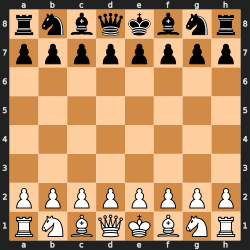

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Move history: Début de la partie :
Scores shape: 10 tokens, torch.Size([5, 50257]) per token

Processing candidate sequence 1/5...
test cut spaces:  e
Prochain coup :  e4
longueur du coup : 3
Nombre de tokens dans 'tokenized_move': 2
longueur des step_scores : 10

Calcul des probabilités pour le coup : [304, 19] (en tokens)
Token 1: ' e' (ID: 304) - Probabilité: 0.775206
Token 2: '4' (ID: 19) - Probabilité: 1.000000
Probabilité cumulative pour le coup : 0.775206


Processing candidate sequence 2/5...
test cut spaces:  d
Prochain coup :  d4
longueur du coup : 3
Nombre de tokens dans 'tokenized_move': 2
longueur des step_scores : 10

Calcul des probabilités pour le coup : [288, 19] (en tokens)
Token 1: ' d' (ID: 288) - Probabilité: 0.224794
Token 2: '4' (ID: 19) - Probabilité: 1.000000
Probabilité cumulative pour le coup : 0.224794


Processing candidate sequence 3/5...
test cut spaces:  d
Prochain coup :  d4
longueur du coup : 3
Nombre de tokens dans 'tokenized_move': 2
longueur des st

In [ ]:
# Lancer le test interactif
test_chess_model()